# UNet

En este notebook se implementa la arquitectura UNet para la segmentación de imágenes.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importamos las librerias necesarias
import os
from pathlib import Path
from PIL import Image
import numpy as np

path = Path('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/') # Path del dataset
print(path)
images_train = sorted([path/'train'/i for i in os.listdir(path/'train')]) # path de las imagenes de entrenamiento
print(images_train)
mascaras_train = sorted([path/'masktrain'/i for i in os.listdir(path/'masktrain')]) # path de las mascaras de entrenamiento
print(mascaras_train)
images_test = sorted([path/'valid'/i for i in os.listdir(path/'valid')]) # path de las imagenes de test
mascaras_test = sorted([path/'masktest'/i for i in os.listdir(path/'masktest')]) # path de las mascaras de test

/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation
[PosixPath('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/train/platillos_0_jpg.rf.129f37b9157824afa37e7001fff33651.jpg'), PosixPath('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/train/platillos_0_jpg.rf.6668c272da0b321fc4ad1f96f3d49438.jpg'), PosixPath('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/train/platillos_0_jpg.rf.ed3cb2b06ba03df3a9bedce9c7662587.jpg'), PosixPath('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/train/platillos_100_jpg.rf.4b377c8ce4064ebdfcf3ad38973ac605.jpg'), PosixPath('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/train/platillos_100_jpg.rf.73f635b6dc214e6d16382f60470ceba7.jpg'), PosixPath('/content/drive/MyDrive/2-SIS421/2parcial/Platos.v1i.coco-segmentation/train/platillos_100_jpg.rf.90decd94dc20c9d56c0c55c380561998.jpg'), PosixPath('/content/drive/MyDrive/2-SIS421/2par

La función `cargar_imagenes_y_mascaras` carga las imágenes y las máscaras de la carpeta `data` y las devuelve en forma de `numpy array`. Esto con el fin de hacer algo más después, hiremos viendo el por qué.

In [ ]:
# Función para cargar imágenes y máscaras como arrays de numpy
def cargar_imagenes_y_mascaras(img_paths, mask_paths):
    imagenes = []
    mascaras = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar imágenes y máscaras con Pillow
        imagen = Image.open(img_path)
        mascara = Image.open(mask_path)
        # convertir a float la imagen
        imagen = np.array(imagen)/255.
        # convertir a float la mascara
        mascara = np.array(mascara)/255.

        # Convertir imágenes y máscaras a arrays de numpy
        imagen_array = np.array(imagen)
        mascara_array = np.array(mascara)

        # Agregar arrays de numpy a las listas
        imagenes.append(imagen_array)
        mascaras.append(mascara_array)

    return np.array(imagenes), np.array(mascaras)

In [ ]:
# Cargar imágenes y máscaras como arrays de numpy
imagenes_numpy, mascaras_numpy = cargar_imagenes_y_mascaras(images_test, mascaras_test)

# Verificar las formas de los arrays de numpy
print("Forma de las imágenes numpy:", imagenes_numpy.shape)
print("Forma de las máscaras numpy:", mascaras_numpy.shape)

Forma de las imágenes numpy: (61, 394, 394, 3)
Forma de las máscaras numpy: (61, 394, 394, 4)


Usamos las imagenes de test para hacer un ejercecio que haremos a continuación.

In [ ]:
# cargamnos las imagenes y las mascaras
imgs = imagenes_numpy
masks = mascaras_numpy

In [ ]:
# mostramos las dimensiones de las imagenes y las mascaras
imgs[0].shape, masks[0].shape

((394, 394, 3), (394, 394, 4))

Visualozamos las imagenes y las máscaras. Para ver que todo está bien y que las máscaras son correctas.

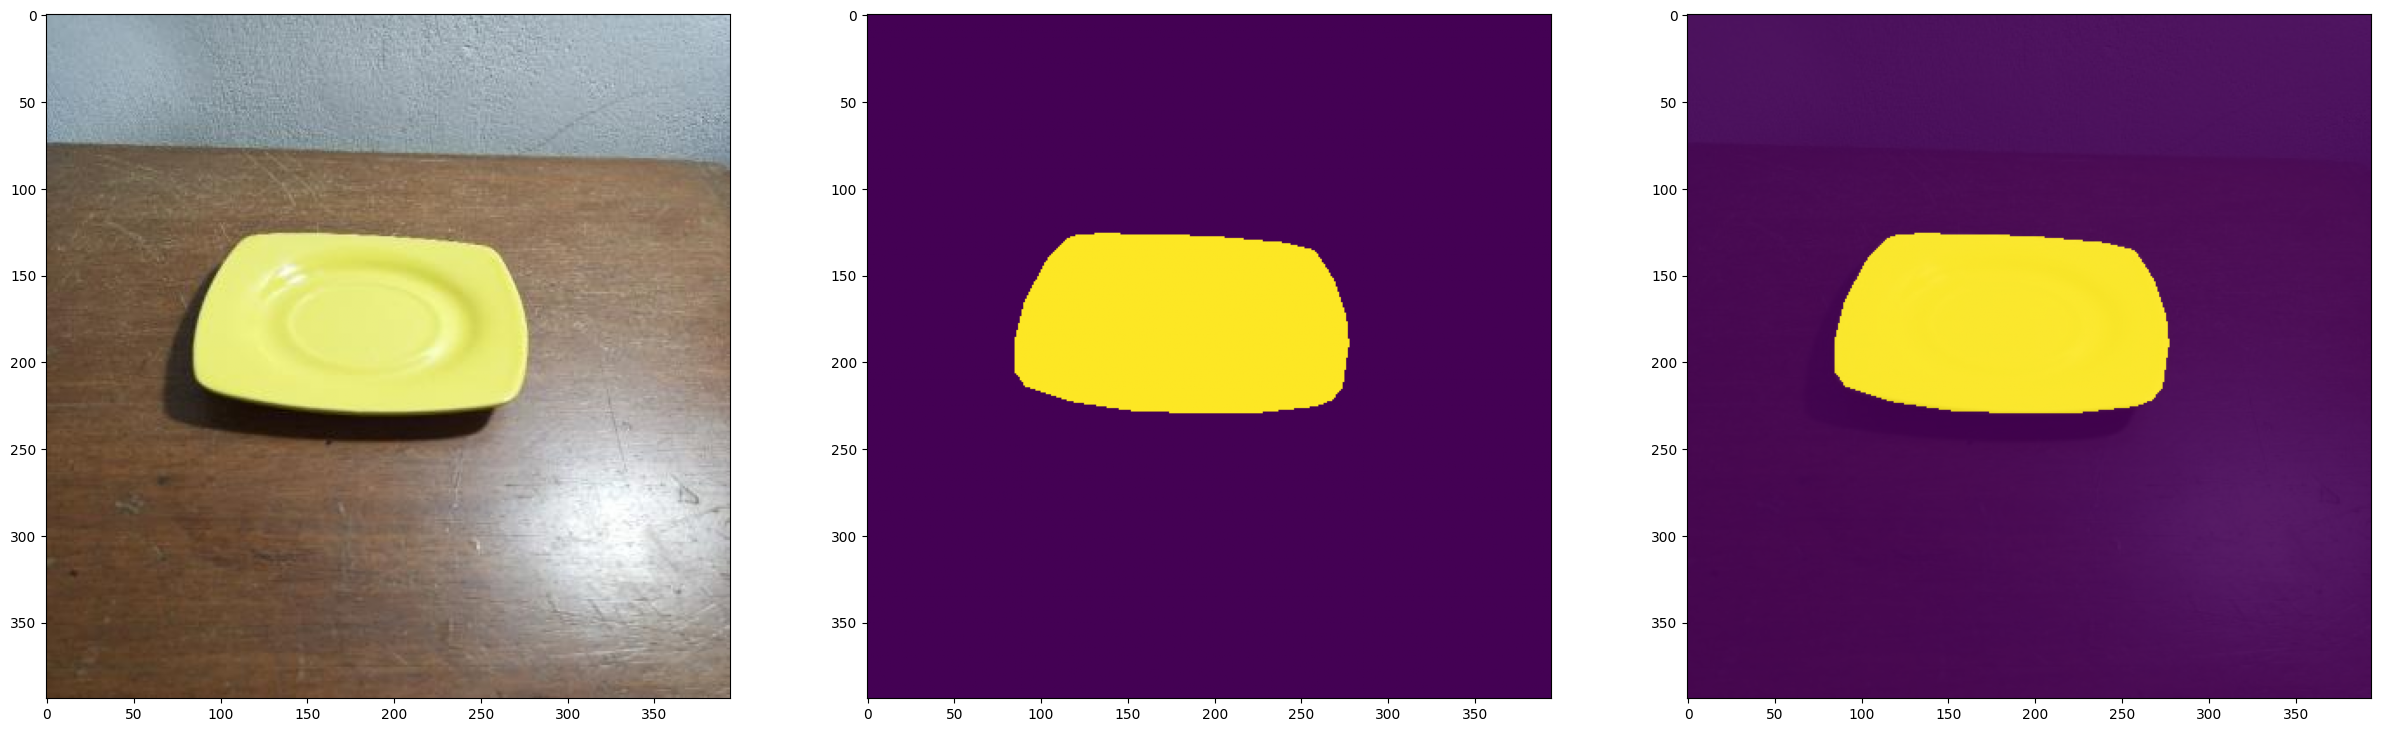

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

#idx = random.randint(0, len(imgs)-1)
#print(idx)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = imgs[15]
mask = masks[15]
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.9)
plt.show()

In [ ]:
# verificamos la dimensión y el tipo de dato de las imagenes
img.shape, img.dtype, img.max(), img.min()

((394, 394, 3), dtype('float64'), 1.0, 0.0)

In [ ]:
# verificamos la dimensión y el tipo de dato de las mascaras
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394, 4), dtype('float64'), 1.0, 0.00392156862745098)

## Modelo UNet

Aquí implementaremos el modelo `UNet`. Este modelo es una arquitectura de red neuronal convolucional para la segmentación de imágenes. Fue desarrollada en 2015 por Olaf Ronneberger, Philipp Fischer y Thomas Brox en la Universidad de Friburgo y ganó la competencia ISBI de segmentación de células neuronales. El modelo UNet se basa en una arquitectura de red neuronal totalmente convolucional para realizar la segmentación de imágenes. Su arquitectura se basa en una red neuronal convolucional en forma de U, por lo que se le llama UNet.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [ ]:
import torch.nn.functional as F
import torch

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# funcion encoder
def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# clase UNet
class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        #print(x.shape, x3.shape, x2.shape, x1.shape)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

Hacemos las pruebas para ver que todo está bien.

In [ ]:
model = UNet()
output = model(torch.randn((1,3,512,512)))
output.shape

torch.Size([1, 4, 512, 512])

### Hacemos el fit de una imagen

Haremos el fit de una imagen para ver que realmente esta funcionando el modelo. Para ello, usaremos la imagen `img` y la máscara `mask` de la función `cargar_imagenes_y_mascaras`.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()  # Convertir X a tipo float
        y = y.float()  # Convertir y a tipo float
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Preparamos la imagen y la máscara con la que vamos a trabajar.

In [ ]:
img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 394, 394]), torch.Size([1, 4, 394, 394]))

In [ ]:
# entrenamos el modelo con una imagen
fit(model, img_tensor, mask_tensor, epochs=20)

Epoch 1/20 loss 0.76565
Epoch 2/20 loss 0.73785
Epoch 3/20 loss 0.72165
Epoch 4/20 loss 0.70884
Epoch 5/20 loss 0.69823
Epoch 6/20 loss 0.68877
Epoch 7/20 loss 0.68069
Epoch 8/20 loss 0.67349
Epoch 9/20 loss 0.66671
Epoch 10/20 loss 0.66025
Epoch 11/20 loss 0.65410
Epoch 12/20 loss 0.64816
Epoch 13/20 loss 0.64239
Epoch 14/20 loss 0.63687
Epoch 15/20 loss 0.63167
Epoch 16/20 loss 0.62665
Epoch 17/20 loss 0.62174
Epoch 18/20 loss 0.61693
Epoch 19/20 loss 0.61231
Epoch 20/20 loss 0.60789


Vemos que el error es demasiado pequeño lo cual nos indica que el modelo está funcionando correctamente.


Pero ahora implementaremos una métrica para medir la precisión del modelo. Para ello, usaremos el `IoU` o `Intersection over Union` que es una métrica que se usa para medir la precisión de un modelo de segmentación. Para ello, usaremos la función `iou_metric` que nos calcula el `IoU` de la máscara predicha y la máscara real.

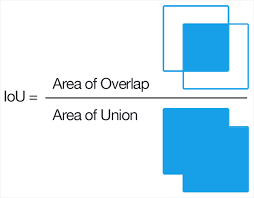

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [ ]:
# entrenamos el modelo con una sola imagen
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.60369 iou 0.62862
Epoch 2/100 loss 0.59620 iou 0.64143
Epoch 3/100 loss 0.58166 iou 0.64755
Epoch 4/100 loss 0.56647 iou 0.64539
Epoch 5/100 loss 0.55405 iou 0.64428
Epoch 6/100 loss 0.54310 iou 0.64494
Epoch 7/100 loss 0.53257 iou 0.64524
Epoch 8/100 loss 0.52233 iou 0.64590
Epoch 9/100 loss 0.51283 iou 0.64632
Epoch 10/100 loss 0.50404 iou 0.64521
Epoch 11/100 loss 0.49582 iou 0.97817
Epoch 12/100 loss 0.48806 iou 0.97786
Epoch 13/100 loss 0.48073 iou 0.97816
Epoch 14/100 loss 0.47361 iou 0.97930
Epoch 15/100 loss 0.46639 iou 0.98059
Epoch 16/100 loss 0.45922 iou 0.98224
Epoch 17/100 loss 0.45218 iou 0.98339
Epoch 18/100 loss 0.44522 iou 0.98431
Epoch 19/100 loss 0.43823 iou 0.98504
Epoch 20/100 loss 0.43128 iou 0.98618
Epoch 21/100 loss 0.42467 iou 0.98640
Epoch 22/100 loss 0.41828 iou 0.98677
Epoch 23/100 loss 0.41218 iou 0.98709
Epoch 24/100 loss 0.40651 iou 0.98766
Epoch 25/100 loss 0.40112 iou 0.98805
Epoch 26/100 loss 0.39595 iou 0.98838
Epoch 27/100 loss 0.3

Vemos que el modelo consigue una precision del `99.12%` lo cual nos indica que el modelo está funcionando correctamente ya que al hacer fit de una sola imagen hacemos overfitting y por eso la precisión es tan alta.

Motramos y predicimos la segmentación de la imagen `img` y la máscara `mask` con la hicimos overfitting al modelo.

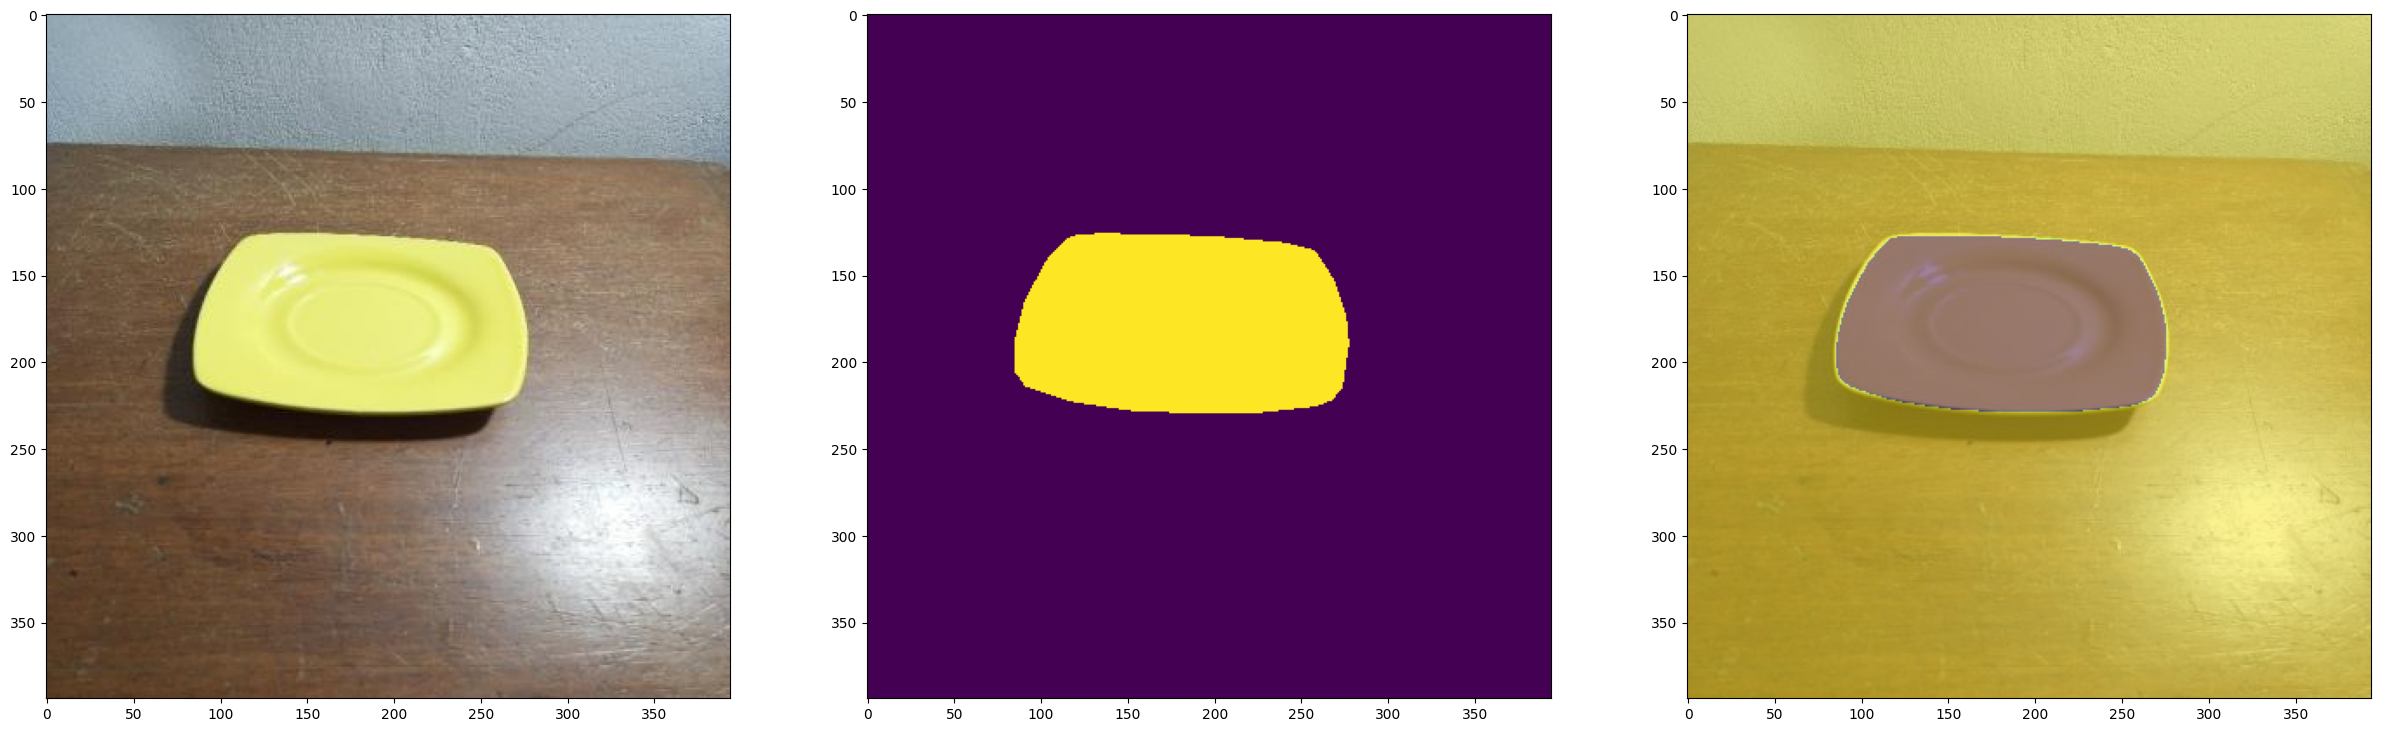

In [ ]:
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.5)
plt.show()

## Entrenamos con todo el dataset

Una vez tenido la certeza de que el modelo esta funcionando correctamente podemos seguir el siguiente paso, que es entrenar el modelo con todo el dataset para eso implementaremos clase `CustomDataset` que nos permitirá cargar el dataset completo y entrenar el modelo con el.

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        imagen = Image.open(self.img_paths[idx])
        mascara = Image.open(self.mask_paths[idx])

        # Convertir imágenes y máscaras a tensores de PyTorch
        X = torch.from_numpy(np.array(imagen) / 255.0).float().permute(2, 0, 1)
        y = torch.from_numpy(np.array(mascara) / 255.0).float().permute(2, 0, 1)

        if self.transform:
            # Aplicar transformación a las imágenes y máscaras
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [ ]:
import torchvision.transforms as transforms

# aplicamos transformaciones a las imagenes
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# creamos el dataset
dataset = {
    'train': CustomDataset(images_train, mascaras_train),
    'test': CustomDataset(images_test, mascaras_test)
}
# verificamos el tamaño del dataset
len(dataset['train']), len(dataset['test'])

(975, 61)

In [ ]:
# vemos la dimensiones de la imagenes y mascaras del dataset
dataset['train'][0][0].shape, dataset['train'][0][1].shape

(torch.Size([3, 394, 394]), torch.Size([4, 394, 394]))

In [ ]:
# cargamos el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 394, 394]), torch.Size([16, 4, 394, 394]))

Implementamos la función `fit` que nos permitirá entrenar el modelo con todo el dataset.

In [ ]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()

        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        torch.save(model.state_dict(), f"/content/drive/MyDrive/2-SIS421/Checkpoint/UNetResNet_model_seg_{epoch}.pt")

    return hist

#### Entrenamos el modelo

Entrenamos el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente.

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=10)

test_loss 0.48403 test_iou 0.52020: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]



Epoch 1/10 loss 0.54887 iou 0.36058 test_loss 0.48403 test_iou 0.52020


test_loss 0.43110 test_iou 0.57478: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]



Epoch 2/10 loss 0.44672 iou 0.60448 test_loss 0.43110 test_iou 0.57478


test_loss 0.41509 test_iou 0.56624: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]



Epoch 3/10 loss 0.41576 iou 0.60978 test_loss 0.41509 test_iou 0.56624


test_loss 0.39786 test_iou 0.60161: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]



Epoch 4/10 loss 0.39959 iou 0.63831 test_loss 0.39786 test_iou 0.60161


test_loss 0.40294 test_iou 0.64821: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]



Epoch 5/10 loss 0.39216 iou 0.64869 test_loss 0.40294 test_iou 0.64821


test_loss 0.38299 test_iou 0.66749: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]



Epoch 6/10 loss 0.38223 iou 0.66968 test_loss 0.38299 test_iou 0.66749


test_loss 0.38331 test_iou 0.67220: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]



Epoch 7/10 loss 0.37519 iou 0.68998 test_loss 0.38331 test_iou 0.67220


test_loss 0.38822 test_iou 0.70013: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]



Epoch 8/10 loss 0.37031 iou 0.70327 test_loss 0.38822 test_iou 0.70013


test_loss 0.37731 test_iou 0.66892: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]



Epoch 9/10 loss 0.36535 iou 0.71725 test_loss 0.37731 test_iou 0.66892


test_loss 0.40511 test_iou 0.67585: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Epoch 10/10 loss 0.36313 iou 0.71829 test_loss 0.40511 test_iou 0.67585


Vemos que la precisión de nuestro modelo es bastante bajo lo cual nos indica que el modelo carece de datos o que necesita más tiempo de entrenamiento.

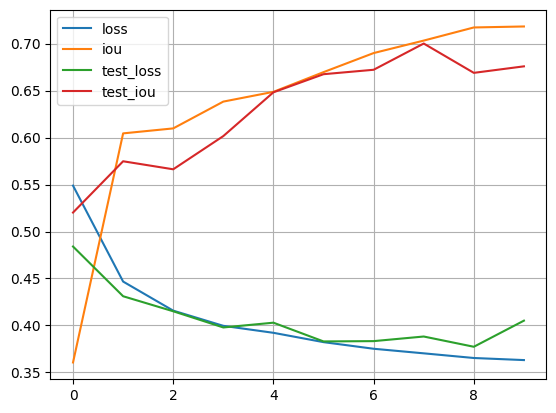

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [ ]:
classes = ['background','platillos', 'platosegundo', 'platosopero']
colors = ['#1f77b4', '#008000', '#ff0000', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    #print(colored_mask)
    for i in range(len(classes)):
        print(i)
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

0
1
2
3


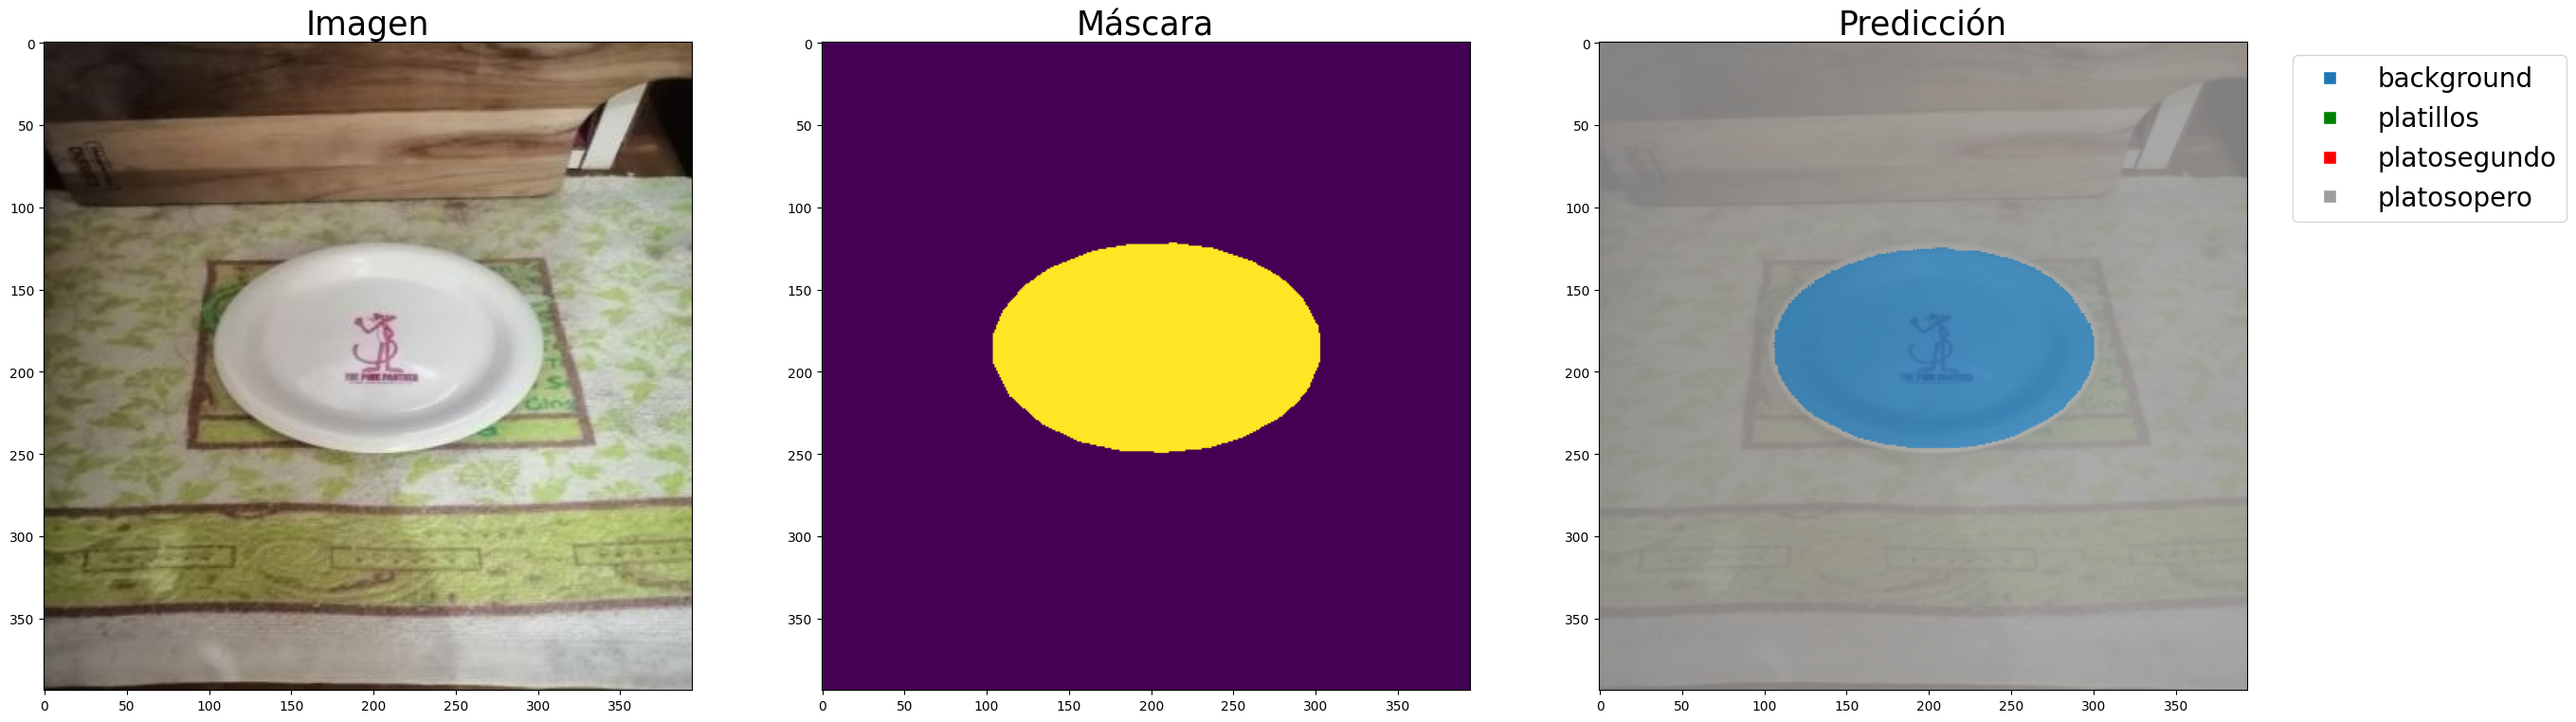

In [ ]:
import random
import matplotlib.colors as mcolors
ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

### UNet con ResNet18

Para solucionar el problema anteriormente que obtuvimos, usaremos la arquitectura `ResNet18` que nos permitirá mejorar la precisión del modelo y haciendo uso del transfer learning.

In [ ]:
import torchvision

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

Probamos para ver que todo este correctamente.

In [ ]:
model = UNetResnet()
output = model(torch.randn((1,3,512,512)))
output.shape

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s]


torch.Size([1, 4, 512, 512])

#### Entrenamos el modelo

Procedemos a entrenar el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente.

In [ ]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=10)

test_loss 0.46402 test_iou 0.81163: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]



Epoch 1/10 loss 0.53828 iou 0.54630 test_loss 0.46402 test_iou 0.81163


test_loss 0.39922 test_iou 0.89020: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]



Epoch 2/10 loss 0.43051 iou 0.83677 test_loss 0.39922 test_iou 0.89020


test_loss 0.36871 test_iou 0.91515: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]



Epoch 3/10 loss 0.38074 iou 0.92670 test_loss 0.36871 test_iou 0.91515


test_loss 0.34262 test_iou 0.94862: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]



Epoch 4/10 loss 0.35130 iou 0.94710 test_loss 0.34262 test_iou 0.94862


test_loss 0.32782 test_iou 0.95651: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]



Epoch 5/10 loss 0.33188 iou 0.96033 test_loss 0.32782 test_iou 0.95651


test_loss 0.31866 test_iou 0.96188: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]



Epoch 6/10 loss 0.31831 iou 0.97296 test_loss 0.31866 test_iou 0.96188


test_loss 0.31129 test_iou 0.96211: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]



Epoch 7/10 loss 0.31010 iou 0.97585 test_loss 0.31129 test_iou 0.96211


test_loss 0.30906 test_iou 0.95771: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]



Epoch 8/10 loss 0.30600 iou 0.97135 test_loss 0.30906 test_iou 0.95771


test_loss 0.30555 test_iou 0.95328: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]



Epoch 9/10 loss 0.30297 iou 0.96686 test_loss 0.30555 test_iou 0.95328


test_loss 0.30600 test_iou 0.95439: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]



Epoch 10/10 loss 0.29975 iou 0.96805 test_loss 0.30600 test_iou 0.95439


Vemos que la precisióon de nuestro modelo mejoró bastante a comparación del modelo anterior llegando a una precisión de `81.90%`.

In [ ]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(model.state_dict(), '/content/drive/MyDrive/2-SIS421/Checkpoint/modelo_UNet_394x394.pth')

In [ ]:
# Crear una instancia del modelo
modelo_cargado =UNetResnet()
# Cargar los parámetros del modelo guardado en la instancia
modelo_cargado.load_state_dict(torch.load('/content/drive/MyDrive/2-SIS421/Checkpoint/modelo_UNet_394x394.pth'))

<All keys matched successfully>

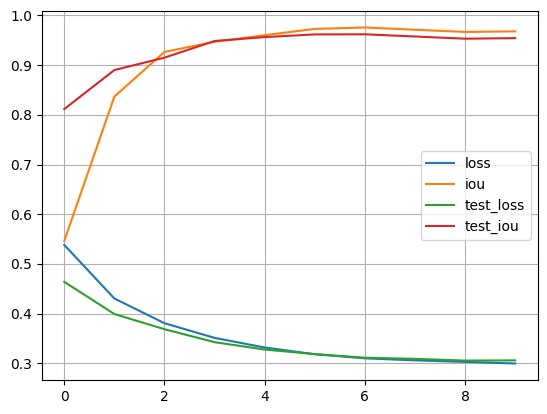

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

0
1
2
3


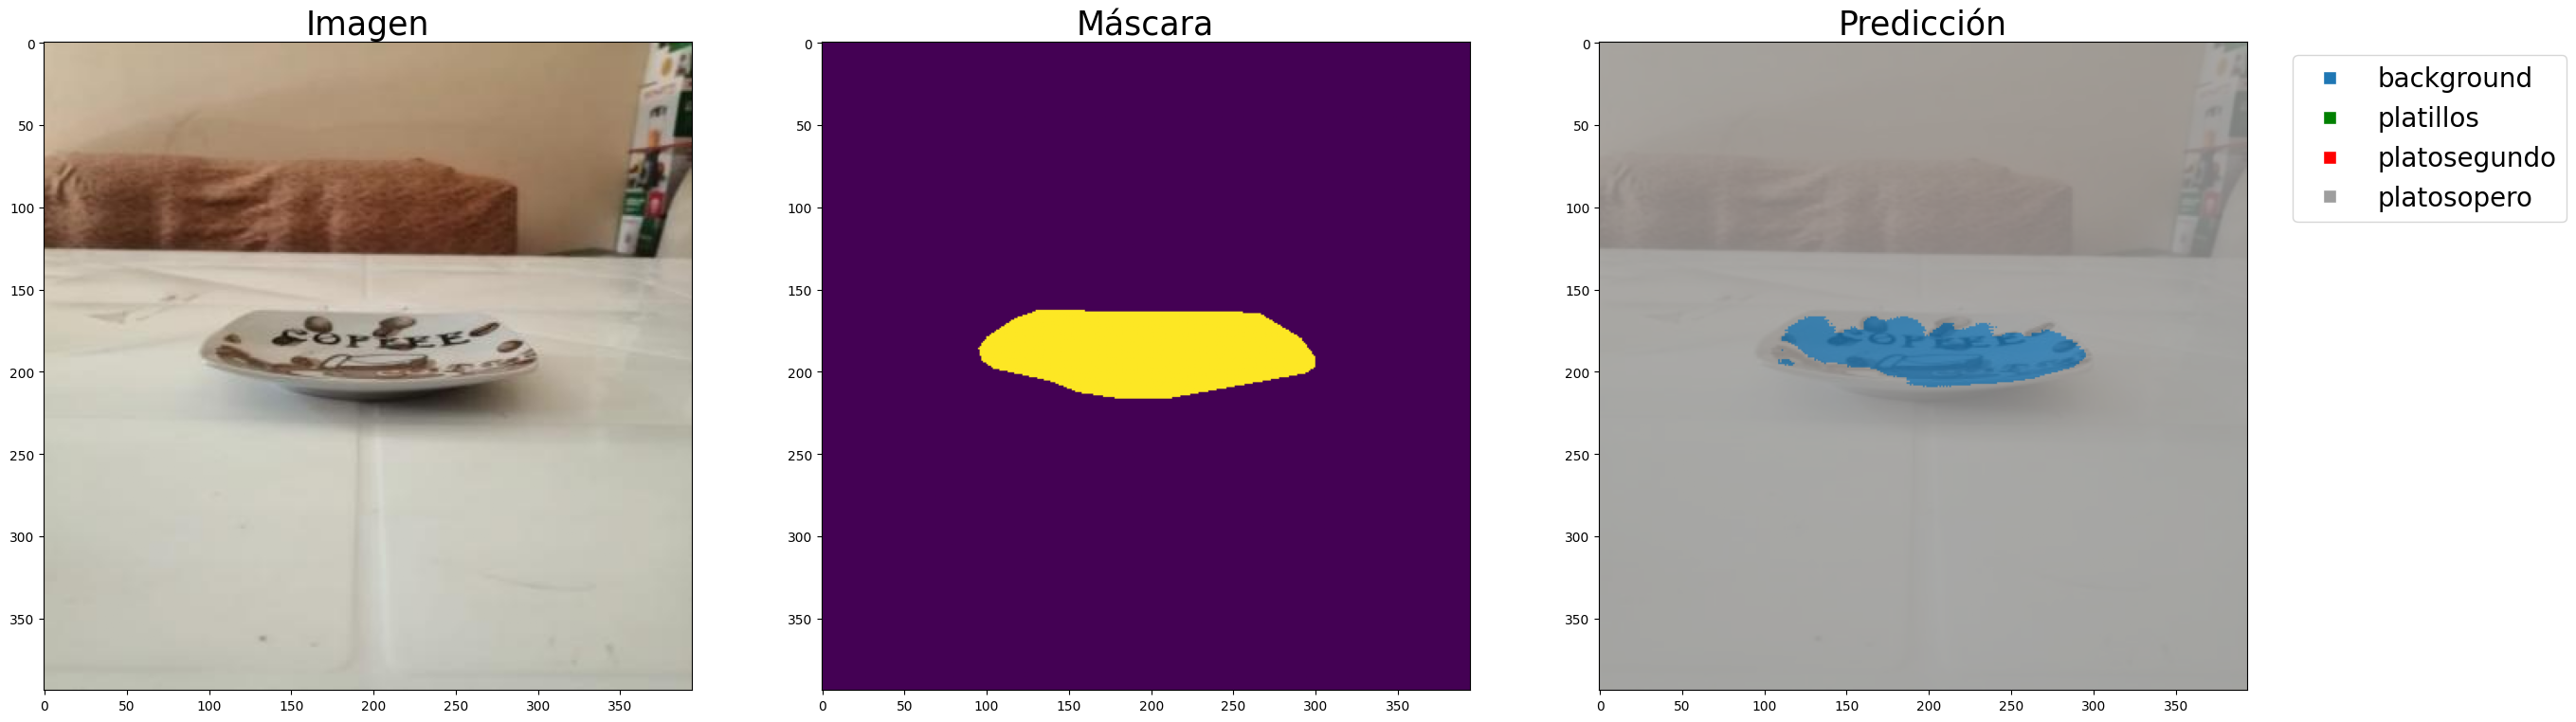

In [ ]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

#### Reentrenameinto

Ahora haremos un reentrenamiento del modelo para ver si mejora la precisión del modelo con un `learning rate` más pequeño. Para eso cargaremos el modelo anterior que lo guardamos y procedemos a reentrenarlo. Para ver si se logra algunas mejoras.

In [ ]:
# cargar modelo
model = UNetResnet()
model.load_state_dict(torch.load('/content/drive/MyDrive/2-SIS421/Checkpoint/modelo_UNet_394x394.pth'))

<All keys matched successfully>

Efectivamente, el modelo mejora su precisión a `87.80%` después de reentrarlo con un `learning rate` más pequeño.

0
1
2
3


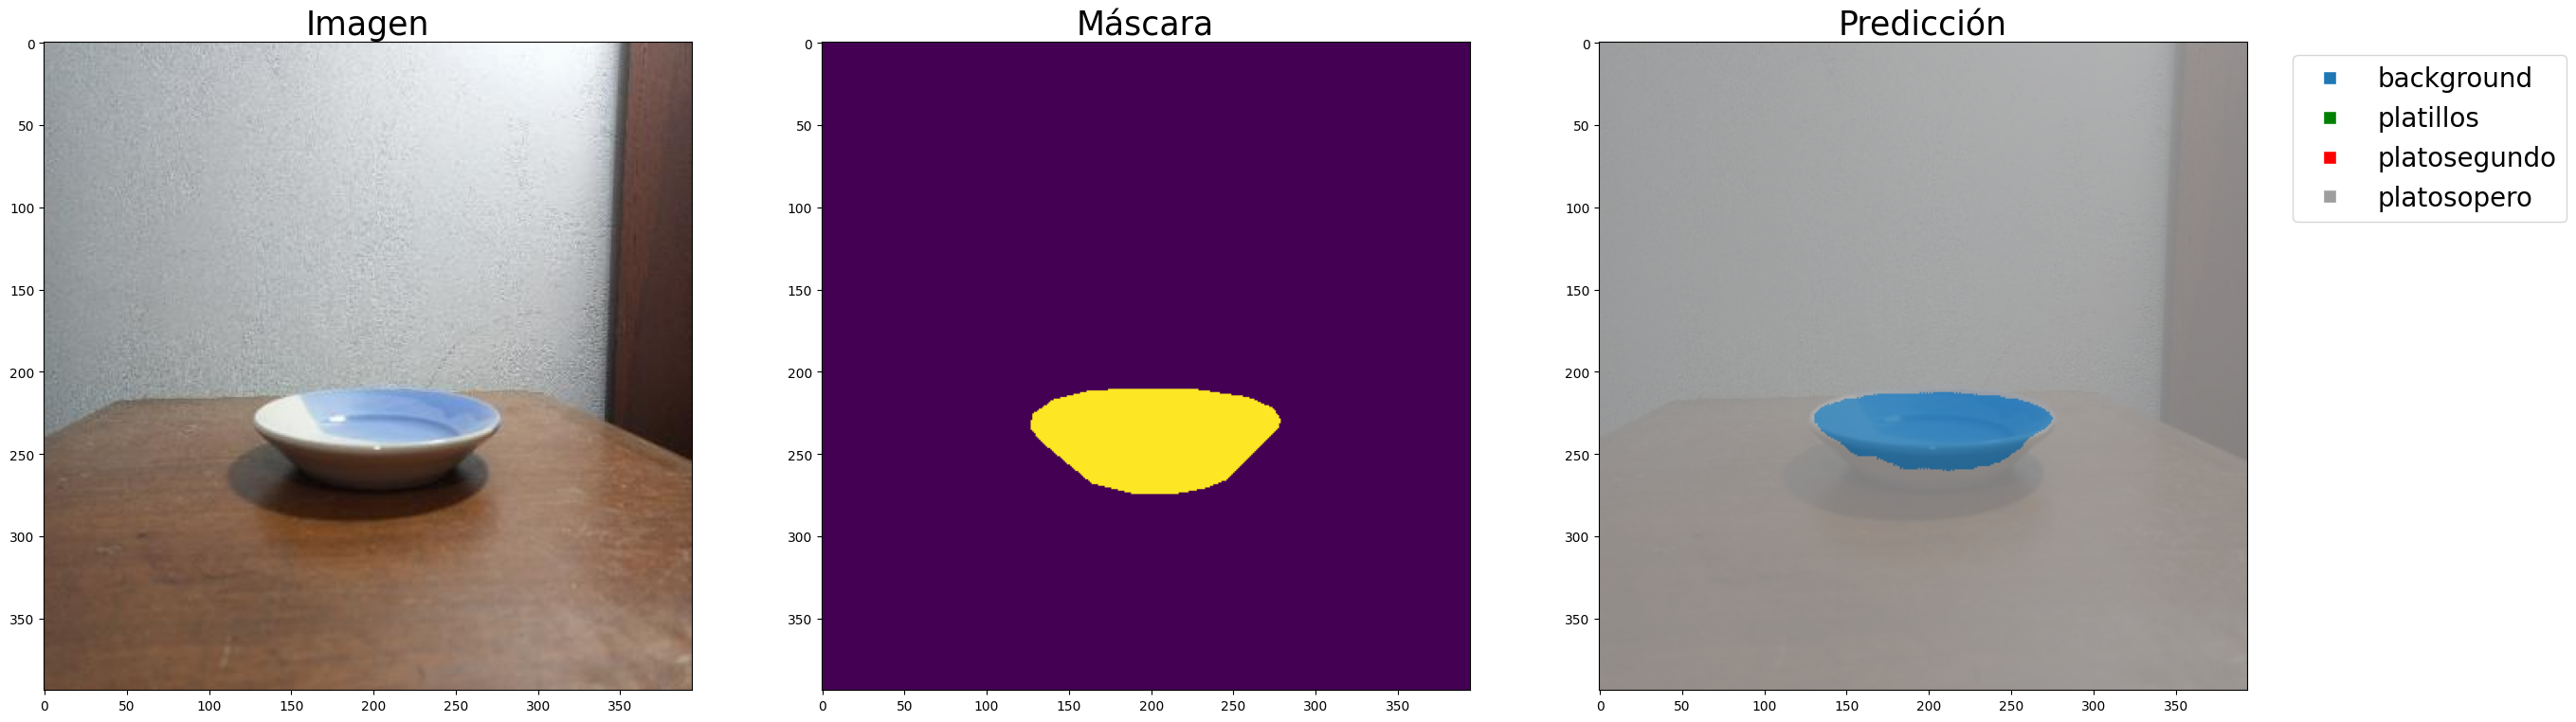

In [ ]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)